# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [3]:
import pickle
import time
import random
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import matplotlib.pyplot as plt
%matplotlib inline

from skimage import transform
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage.exposure import rescale_intensity

import cv2

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
unique_label = []
for label in test['labels']:
    if (label not in unique_label):
        unique_label.append(label)
n_classes = len(unique_label)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

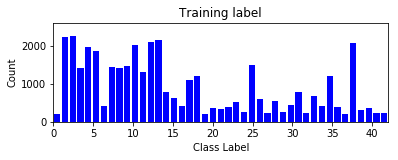

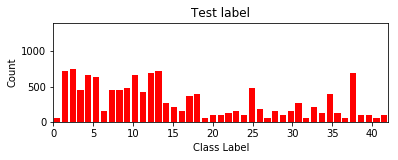

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# Plot the histogram on training label
plt.subplot(2,1,1)
plt.axis([0, 42, 0, 2600])
plt.hist(y_train, n_classes,rwidth=0.8, color = 'blue')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Training label')
plt.show()

# Plot the histogram on test label
plt.subplot(2,1,2)
plt.axis([0, 42, 0, 1400])
plt.hist(y_test, n_classes, rwidth=0.8, color = 'red')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Test label')
plt.show()

In [4]:
def generate_images(img):
    random_angle = np.random.uniform(-60, 60)
    row, col = img.shape[0:2]
    rotated_img = cv2.getRotationMatrix2D((col/2,row/2), random_angle,1)
    output = cv2.warpAffine(img, rotated_img,(col ,row))
    
    return output

In [7]:
# Make sure each class has same number of dataset 
count_class = np.bincount(y_train)
#print(max(count_class)) #2250

for i in range(n_classes):     
    X_added, y_added = [], []
    imgs_with_label_i = X_train[np.where(y_train == i)]


    imgs_to_add = 2300 - count_class[i]
    
    for j in range(imgs_to_add):
        img_to_add_random_idx = np.random.randint(count_class[i])
        X_added.append(generate_images(imgs_with_label_i[img_to_add_random_idx]))
        y_added.append(i)
        
    X_train = np.append(X_train, X_added, axis=0)
    y_train = np.append(y_train, y_added, axis=0)

X_train.shape

(98900, 32, 32, 3)

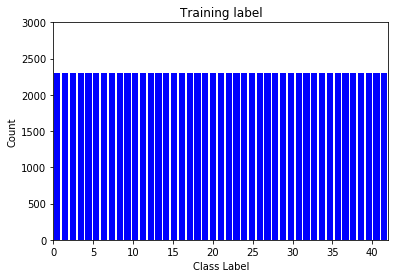

In [8]:
# Each classes' train dataset size after balancing
plt.axis([0, 42, 0, 3000])
plt.hist(y_train, n_classes,rwidth=0.8, color = 'blue')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Training label')
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** 

* A histogram is generated to explore the symmetry of the training dataset for all 43 labels. It is important to undertand the training dataset and to ensure different classes have similar dataset distribution, so the model could be trained without biases.


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** 
* 80% of the data are used for training and 20% are used for validation.
* The histogram shows a highly unbalanced dataset, and additional data needs to be generated. To generate the addional data, I used opencv package to generate a rotated version of the original image. The rotating angle follows an uniform distribution between -60 and +60 degree. 


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
* The final architecture has 3 convolutional layers, 3 max pooling layers with a 3 x 3 block and 3 fully connected layers.
* The first convolutional layer has a 32@28 x 28 output, the second convolutional layer has a 64@24 x 24 output and the third convolutional layer has a 64@18 x 18 output.
* All convolutional layers and max pooling layers are "VALID" padded.
* The first fully connected layer has 1024 parameters, the second FC layers has 512 parameters and the thrid FC layer has 128 parameters


In [60]:
def CNN(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0.0
    sigma = 0.1
    weights = {
        'wc1': tf.Variable(tf.truncated_normal((5, 5, 3, 32), mean = mu, stddev = sigma)),
        'wc2': tf.Variable(tf.truncated_normal((3, 3, 32, 64), mean = mu, stddev = sigma)),
        'wc3': tf.Variable(tf.truncated_normal((5, 5, 64, 64), mean = mu, stddev = sigma)),
        'wf1': tf.Variable(tf.truncated_normal((1024, 512), mean = mu, stddev = sigma)),
        'wf2': tf.Variable(tf.truncated_normal((512, 128), mean = mu, stddev = sigma)),
        'wf3': tf.Variable(tf.truncated_normal((128, 43), mean = mu, stddev = sigma))
    }
    
    biases = {
        'bc1': tf.Variable(tf.zeros(32)),
        'bc2': tf.Variable(tf.zeros(64)),
        'bc3': tf.Variable(tf.zeros(64)),
        'bf1': tf.Variable(tf.zeros(512)),
        'bf2': tf.Variable(tf.zeros(128)),
        'bf3': tf.Variable(tf.zeros(43))
    }
    # TODO: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x32.
    conv_layer1 = tf.nn.conv2d(x, weights['wc1'], strides = [1, 1, 1, 1], padding = 'VALID')
    conv_layer1 = tf.nn.bias_add(conv_layer1, biases['bc1'])
    
    # TODO: Activation.
    conv_layer1 = tf.nn.relu(conv_layer1)
    # TODO: Pooling. Input = 28x28x32. Output = 26x26x32.
    conv_layer1 = tf.nn.max_pool(conv_layer1, ksize = [1, 3, 3, 1], strides = [1, 1, 1, 1], padding = 'VALID')
    
    # TODO: Layer 2: Convolutional. Output = 24x24x64.
    conv_layer2 = tf.nn.conv2d(conv_layer1, weights['wc2'], strides = [1, 1, 1, 1], padding = 'VALID')
    conv_layer2 = tf.nn.bias_add(conv_layer2, biases['bc2'])
    
    # TODO: Activation.
    conv_layer2 = tf.nn.relu(conv_layer2)
    # TODO: Pooling. Input = 24x24x64. Output = 22x22x64.
    conv_layer2 = tf.nn.max_pool(conv_layer2, ksize = [1, 3, 3, 1], strides = [1, 1, 1, 1], padding = 'VALID')

    # TODO: Layer 3: Convolutional. Output = 18x18x64.
    conv_layer3 = tf.nn.conv2d(conv_layer2, weights['wc3'], strides = [1, 1, 1, 1], padding = 'VALID')
    conv_layer3 = tf.nn.bias_add(conv_layer3, biases['bc3'])
    
    # TODO: Activation.
    conv_layer3 = tf.nn.relu(conv_layer3)
    # TODO: Pooling. Input = 18x18x64. Output = 4x4x64.
    conv_layer3 = tf.nn.max_pool(conv_layer3, ksize = [1, 3, 3, 1], strides = [1, 4, 4, 1], padding = 'VALID')
    
#     print(conv_layer3.get_shape())
    # TODO: Flatten. Input = 4x4x64. Output = 1024.
    fc0 = flatten(conv_layer3)
#     print(fc0.get_shape())
    
    # TODO: Layer 4: Fully Connected. Input = 1024. Output = 512.
    fc1 = tf.add(tf.matmul(fc0, weights['wf1']), biases['bf1'])
    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)
#     print(fc1.get_shape())

    # TODO: Layer 5: Fully Connected. Input = 512. Output = 256.
    fc2 = tf.add(tf.matmul(fc1, weights['wf2']), biases['bf2'])

    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)

    # TODO: Layer 6: Fully Connected. Input = 256. Output = 43.
    fc3 = tf.add(tf.matmul(fc2, weights['wf3']), biases['bf3'])
    logits = fc3
    
    return logits

In [61]:
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [62]:
EPOCHS = 100
BATCH_SIZE = 128*1
rate = 0.0003

logits = CNN(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [63]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [64]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    valid_acc = []
    print("Training...")
    print()
    for i in range(EPOCHS):
        t0 = time.time()
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Time: %.3f seconds" % (time.time() - t0))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        valid_acc.append(validation_accuracy)
        
    saver.save(sess, './train_model')
    print("Model saved")

Training...

EPOCH 1 ...
Time: 39.223 seconds
Validation Accuracy = 0.028

EPOCH 2 ...
Time: 39.148 seconds
Validation Accuracy = 0.046

EPOCH 3 ...
Time: 39.144 seconds
Validation Accuracy = 0.076

EPOCH 4 ...
Time: 39.159 seconds
Validation Accuracy = 0.108

EPOCH 5 ...
Time: 39.175 seconds
Validation Accuracy = 0.132

EPOCH 6 ...
Time: 39.208 seconds
Validation Accuracy = 0.178

EPOCH 7 ...
Time: 39.181 seconds
Validation Accuracy = 0.273

EPOCH 8 ...
Time: 39.161 seconds
Validation Accuracy = 0.364

EPOCH 9 ...
Time: 39.166 seconds
Validation Accuracy = 0.497

EPOCH 10 ...
Time: 39.212 seconds
Validation Accuracy = 0.602

EPOCH 11 ...
Time: 39.183 seconds
Validation Accuracy = 0.657

EPOCH 12 ...
Time: 39.188 seconds
Validation Accuracy = 0.705

EPOCH 13 ...
Time: 39.188 seconds
Validation Accuracy = 0.774

EPOCH 14 ...
Time: 39.219 seconds
Validation Accuracy = 0.852

EPOCH 15 ...
Time: 39.190 seconds
Validation Accuracy = 0.886

EPOCH 16 ...
Time: 39.195 seconds
Validation Accura

The maximum validation accuracy is 0.9927325581998024 at epoch 71


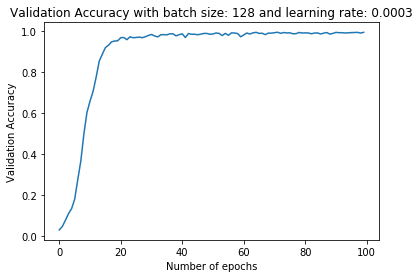

In [65]:
plt.title('Validation Accuracy with batch size: {0} and learning rate: {1}'.format(BATCH_SIZE, rate))
plt.xlabel('Number of epochs')
plt.ylabel('Validation Accuracy')
plt.plot(valid_acc)
print('The maximum validation accuracy is {0} at epoch {1}'.format(np.max(valid_acc), np.argmax(valid_acc)))

In [67]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.944


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
* Adam Optimizer is used, since it is very computational efficient.
* Batch size is 128
* Epochs are 100
* Learning rate is 0.0003
* Used AWS to train the model, each epoch is around 40 seconds

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
* I first used 0.001 learning rate with 50 epochs without dataset balancing, and the validation accuracy reached 98.7% and test accuracy was 93.4%. Then the learning rate was lower to 0.0005 with 50 epochs without dataset balancing, the validation accuracy reached 98.2% and test accuracy was 93.6%.
* After the dataset balancing, I first trained the model with learning rate 0.0005 with 50 epochs, and the validation accuracy reached 98.3% and the test accuracy was only 91.5%. The validation curve flunctuated a little and the learning rate was lower to 0.0003 with 100 epochs, and finally achieved a 94.4% test accuracy.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

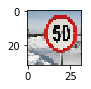

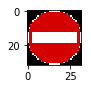

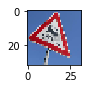

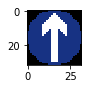

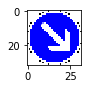

In [68]:
import matplotlib.image as mpimg

test_img = []

test_label = [2, 17, 23, 35, 38]


file_name = ['label_2.png','label_17.png','label_23.png', 'label_35.png', 'label_38.png']

for file in file_name:
    img = mpimg.imread('test_own_data/' + file)
    img = cv2.resize(img, (32, 32))
    img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    test_img.append(img)

for i in range(len(file_name)):
    plt.figure(figsize=(1,1))
    plt.imshow(test_img[i])
    

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
* The first speed limit image is taken in a snow environment, the background might be difficult to recognize. 

In [80]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    test_accuracy = evaluate(test_img, test_label)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.400


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
* The new image test accuracy is 40%. The first image is class "2": speed limit(50km/h), the second image is class "17": No entry, the third image is class "23": Slippery road, the fourth image is class "35": Ahead only and the fifth image is class "38": Keep right.

In [81]:
softmax = tf.nn.softmax(logits)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    prediction = sess.run(softmax, feed_dict = {x: test_img})
    top_k = tf.nn.top_k(softmax, 4)
    val, idx = sess.run(top_k, feed_dict = {x: test_img})

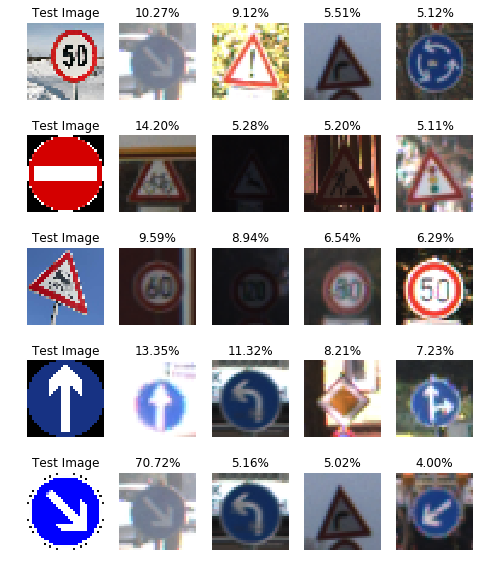

In [73]:
rows, cols = idx.shape

fig, axes = plt.subplots(rows, cols+1, figsize=(cols*2, rows*2))
for i, row in enumerate(axes):
    row[0].axis('off')
    row[0].imshow(test_img[i])
    row[0].set_title("Test Image")

    for j in range(cols):
        row[j+1].axis('off')
        row[j+1].imshow(X_train[np.where(y_train == idx[i][j])][100])
        row[j+1].set_title("{:.2f}%".format(val[i,j]*100))    

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
* For the first image, the model thinks 10.7% chance the sign is a "keep right" sign and 9.12% chance it is a "general caution" sign. I am quite curious about why the model would think the speed limit sign as a keep right sign, since the color of the sign is quite different as well as the shape.
* For the second image, the model thinks 14.2% chance the sign is a "Pedestrains" sign.
* For the third image, the model thinks 9.59% chace the sign is a "Speed limit (60km/h)" sign. It is interesting to notice that the top 4 choices are all speed limit signs. Maybe because the slippery road sign has a strong red and white color and the model make the classification based on that.
* For the fourth image where the model makes a correct classification, however only with 13.35% confidence. The second candidate would be "Turn left only" sign.
* For the fifth image, the model thinks 70.72% chance it is a "Keep right" sign, and in fact, it is.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.